In [1]:
import numpy as np
import gym
import random
from collections import namedtuple,deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)

[0]

In [3]:
print(env.observation_space)
print(env.action_space.n)

Box(8,)
4


In [4]:
#parameter
batch_size = 64
max_capacity = int(1e5)
gamma = .99
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
UPDATE_EVERY = 4
LR = 5e-4
TAU = 1e-3

In [5]:
class Agent():
    def __init__(self, state_size, action_size, seed, implement = 'DDQN'):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.local_net = QNetwork(state_size, action_size, seed).to(device)
        self.target_net = QNetwork(state_size, action_size, seed).to(device)
        self.memory = ReplayBuffer(batch_size, max_capacity, seed)
        self.optimizer = optim.Adam(self.local_net.parameters(),lr = LR)
        self.t_steps = 0
        self.implement = implement
        
    def epsilon_greedy(self,action_values,eps):    
        random_gen = random.uniform(0,1)
        if random_gen > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def act(self, state, eps = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_net.eval()
        with torch.no_grad():
            action_values = self.local_net(state)
#             print('Action Values : ',action_values)
#             print('Action Values size : ',action_values.shape)
        self.local_net.train()
        return self.epsilon_greedy(action_values,eps)
    
    def step(self,state,action,reward,next_state,done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_steps = (self.t_steps + 1) % UPDATE_EVERY
        if self.t_steps  == 0:     
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences,gamma)
    
    def learn(self,experiences,gamma):
        
        states,actions,rewards,next_states,dones = experiences
        
        if self.implement == 'DQN':
            targeted_output_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
            
        if self.implement == 'DDQN':
            best_action_local = self.local_net(next_states).max(1)[1].unsqueeze(1)
            Q_target_values = self.target_net(next_states)
            targeted_output_next = torch.gather(Q_target_values,1,best_action_local) 
            
        target_totals = rewards + (gamma*targeted_output_next*(1-dones))
        local_outputs = self.local_net(states).gather(1,actions)
        
        loss = F.mse_loss(local_outputs,target_totals)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        #updating target_net
        self.update(self.local_net,self.target_net,TAU)
    
    def update(self,local_model,target_model,tau):
        
        for local_param,target_param in zip(local_model.parameters(),target_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [6]:
class QNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units = 64,fc2_units = 64):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
        
    def forward(self,state):
        output = F.relu(self.fc1(state))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [7]:
class ReplayBuffer:
    def __init__(self,batch_size,max_capacity,seed):
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.buffer_size = max_capacity
        self.buffer = deque(maxlen = max_capacity)
        self.experience = namedtuple('Experiences',field_names = ['state','action','reward','next_state','done'])
    
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.buffer.append(e)
    
    def sample(self):
        batch = random.sample(self.buffer,k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([b.state for b in batch if b is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([b.action for b in batch if b is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([b.reward for b in batch if b is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([b.next_state for b in batch if b is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([b.done for b in batch if b is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.buffer)

In [8]:
agent = Agent(state_size = 8, action_size = 4, seed = 0, implement = 'DDQN')

In [10]:
state = env.reset()
for j in range(200):
    print(state)
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

[-0.00219984  1.420277   -0.22284153  0.4158522   0.00255593  0.05047693
  0.          0.        ]
[-0.00440016  1.4290553  -0.2225399   0.39013937  0.00505033  0.04989303
  0.          0.        ]
[-0.00660038  1.4372349  -0.2225478   0.3635186   0.00754316  0.04986127
  0.          0.        ]
[-0.0088007   1.4448143  -0.2225552   0.33684763  0.01003569  0.04985518
  0.          0.        ]
[-0.01100102  1.4517938  -0.22256258  0.3101781   0.01252782  0.04984741
  0.          0.        ]
[-0.01320152  1.4581733  -0.22256997  0.28350925  0.01501956  0.04983974
  0.          0.        ]
[-0.01540203  1.4639528  -0.2225773   0.25684056  0.01751091  0.04983186
  0.          0.        ]
[-0.01760263  1.4691324  -0.22258465  0.23017175  0.02000189  0.04982416
  0.          0.        ]
[-0.01980333  1.4737121  -0.22259195  0.20350294  0.02249246  0.04981642
  0.          0.        ]
[-0.02200403  1.4776918  -0.22259924  0.17683403  0.02498266  0.0498087
  0.          0.        ]
[-0.0242049

Episode : 100	 Average Reward : -177.78
Episode : 200	 Average Reward : -93.45
Episode : 300	 Average Reward : -53.39
Episode : 400	 Average Reward : 36.09
Episode : 500	 Average Reward : 132.46
Episode : 600	 Average Reward : 165.08
Episode : 700	 Average Reward : 206.09
Episode : 800	 Average Reward : 239.10
Episode : 845	 Average Score: 250.27
Environment solved in 745 episodes!	Average Score: 250.27


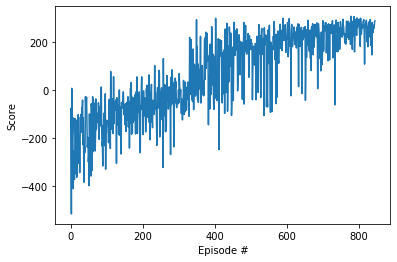

In [11]:
def DDQN(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_min = .01, eps_decay = 0.995, window = 100):
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=window)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        eps = max(eps*eps_decay,eps_min)
        scores.append(score)
        print('\rEpisode : {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode%100 == 0:
            print('\rEpisode : {}\t Average Reward : {:.2f}'.format(i_episode,np.mean(scores_window)))
        if np.mean(scores_window)>=250.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.local_net.state_dict(), 'checkpoint_1.pth')
            break
    return scores

scores = DDQN()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
agent.local_net.load_state_dict(torch.load('checkpoint_1.pth'))
for i_episode in range(10):
    state = env.reset()
    rewards = 0
    for j in range(1000):
        action = agent.act(state)
        env.render()
        next_state,reward,done,_ = env.step(action)
        state = next_state
        rewards += reward
        if done:
            break
    print('\nReward per episode : {}'.format(rewards))

env.close()


Reward per episode : 217.5577394323832

Reward per episode : 291.6899506393073

Reward per episode : 268.14990702892794

Reward per episode : 249.59376676176586

Reward per episode : 249.55969648023347

Reward per episode : 263.9297183036894

Reward per episode : 259.887778195468

Reward per episode : 255.2127371243811

Reward per episode : 295.45342559406777

Reward per episode : 278.9538551305
